<a href="https://colab.research.google.com/github/alegoritma/CSE-ImageProcessing-Project/blob/main/Test_Dataset_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
%load_ext google.colab.data_table

In [ ]:
#@title <- Imports

import os
import sys
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import numpy as np
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

import tensorflow_addons as tfa

from tqdm.notebook import tqdm

import pandas as pd
import json



In [ ]:
PROJECT_ID = "Hidden due to privacy reasons!"

#### Define Utils

In [ ]:

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*(w+10)+10, rows*(h+10)+10))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*(w+10)+10, i//cols*(h+10)+10))
    return grid

def to_square(x1,y1,x2,y2, max_width, max_height):
    new_width = x2-x1
    new_height = y2-y1
    if (new_height > new_width): 
        padding = (new_height - new_width)//2
        x1 = x1-padding
        x2 = x2+padding
        if x1 < 0:
            x2 -= x1; x1 = 0
        if x2 > max_width:
            x1 -= x2 - max_width; x2 = max_width 
        return x1,y1,x2,y2
    else:
        padding = (new_width- new_height)//2
        y1 = y1-padding
        y2 = y2+padding
        if y1 < 0:
            y2 -= y1; y1 = 0
        if y2 > max_height:
            y1 -= y2 - max_width; y2 = max_width 
        return x1,y1,x2,y2
        
def add_padding_to_bbox(df, ratio):
    px = (df["x2"] - df["x1"])*ratio
    py = (df["y2"] - df["y1"])*ratio
    
    df['x1'] = df["x1"]-px
    df["x2"] = df["x2"]+px
    
    df['y1'] = df["y1"]-py
    df["y2"] = df["y2"]+py


    df["x1"][df["x1"]<0]["x1"] = 0.0
    df["y1"][df["y1"]<0]["y1"] = 0.0

    df["x2"][df["x2"]>1]["x2"] = 1.0
    df["y2"][df["y2"]>0]["y2"] = 1.0

    return df
    
def get_optic_disc_coords(predDf):
    return predDf[predDf["classId"] == 13].sort_values('confidence', ascending=False).iloc[0,:][['x1', 'y1', 'x2', 'y2']]

def getBBoxPredDf(detections):
    df = pd.concat([
        pd.DataFrame({
            "classId": detections['detection_classes'][0].numpy().astype(np.uint32),
            "confidence": detections['detection_scores'][0].numpy(),
        }),
        pd.DataFrame(
            detections['detection_boxes'][0].numpy(), columns=['y1', 'x1', 'y2', 'x2']
        )
    ], axis=1)
    
    return df

def parseBboxDf(df):
    return list(df.T.to_dict().values())


#### Download Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CSV_PATH = 'drive/My Drive/testImages/firebase_images_map_validated_with_handpicked.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(CSV_PATH, index_col=0)
df = df[df["Answer"] == 1]

df.type.value_counts()[["normal fundus","glaucoma"]]
df_glc = df[(df["type"] == "glaucoma")]
df_normal = df[df["type"] == "normal fundus"].sample(203)

glc_paths = df_glc["image_path"]
normal_paths = df_normal["image_path"]

In [ ]:
glc_paths_str = "\n".join(glc_paths.values)
normal_paths_str = "\n".join(normal_paths.values)

with open("normal_paths", 'w') as f:
    f.write(normal_paths_str)

with open("glc_paths", 'w') as f:
    f.write(glc_paths_str)

In [ ]:
%%capture
!mkdir normal_data
!mkdir glc_data

!cat normal_paths | gsutil -m cp -I ./normal_data
!cat glc_paths | gsutil -m cp -I ./glc_data

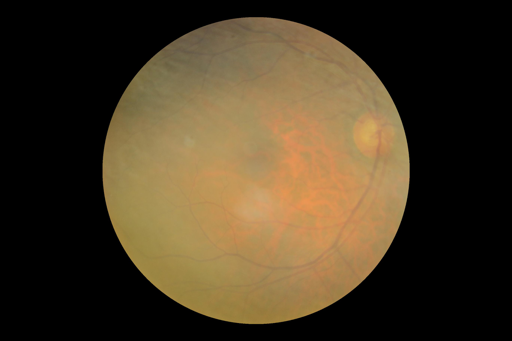

In [ ]:
#@title Sample Image
sample_im = Image.open(f'./glc_data/{os.listdir("./glc_data")[0]}')
sample_im.thumbnail((512,512))
sample_im

#### Download and Load Optic Disc Detection Model

In [ ]:
%%capture
inference_graph_path = f"gs://{PROJECT_ID}/effdet0-odf-train/inference_graph"
!gsutil -m cp -r $inference_graph_path /content/
detect_fn = tf.saved_model.load(f"/content/inference_graph/saved_model")

#### Crop Optic Disc and Save as Image

In [ ]:
for category in tqdm(['normal', 'glc']):
    im_names = os.listdir(f"./{category}_data")

    for im_name in tqdm(im_names):
        im = Image.open(f"./{category}_data/{im_name}")

        width, height = im.size

        image_tensor = tf.convert_to_tensor(np.array(im))
        image_batch_tensor = tf.expand_dims(image_tensor, axis=0)
        detections = detect_fn(image_batch_tensor)

        predDf = getBBoxPredDf(detections)
        predDf = add_padding_to_bbox(predDf, 0.22)
        x1, y1, x2, y2 = get_optic_disc_coords(predDf)
        x1, y1, x2, y2 = int(x1*width), int(y1*height), int(x2*width), int(y2*height)
        
        if (int(x2-x1) < 256 and int(y2-y1) < 256): continue
        
        x1, y1, x2, y2 = to_square(x1, y1, x2, y2, width, height)
        im_bbox = im.crop((x1, y1, x2, y2))
        im_bbox.save(f'./{category}_cropped/{im_name}')


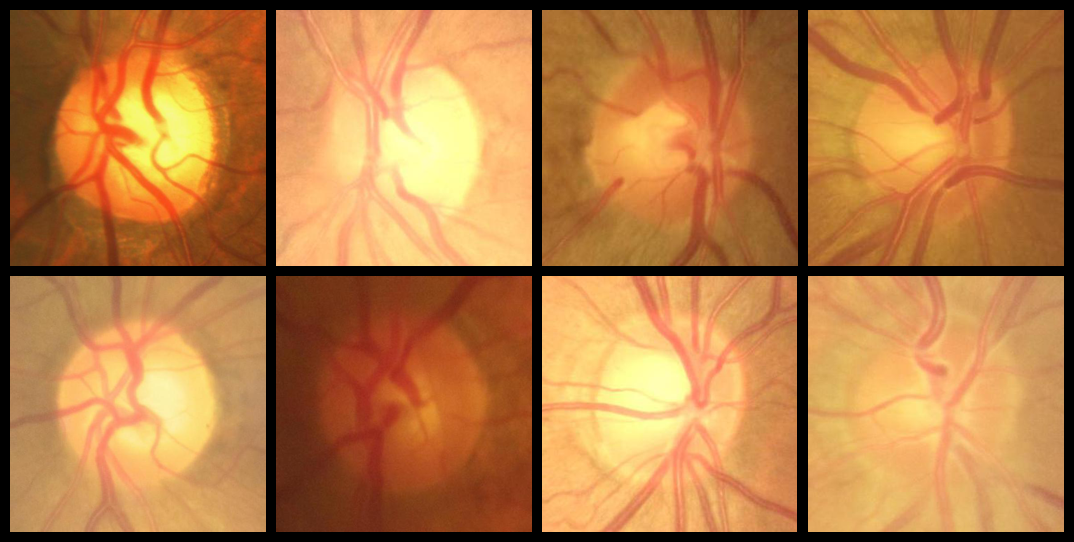

In [ ]:
#@title Cropped Samples from Glaucoma-Negative Images
imgs = []

for im_name in os.listdir('./normal_cropped')[10:18]:
    sample_im = Image.open(f"./normal_cropped/{im_name}")
    sample_im.thumbnail((256,256))
    
    imgs.append(sample_im)

grid = image_grid(imgs, 2, 4)
grid

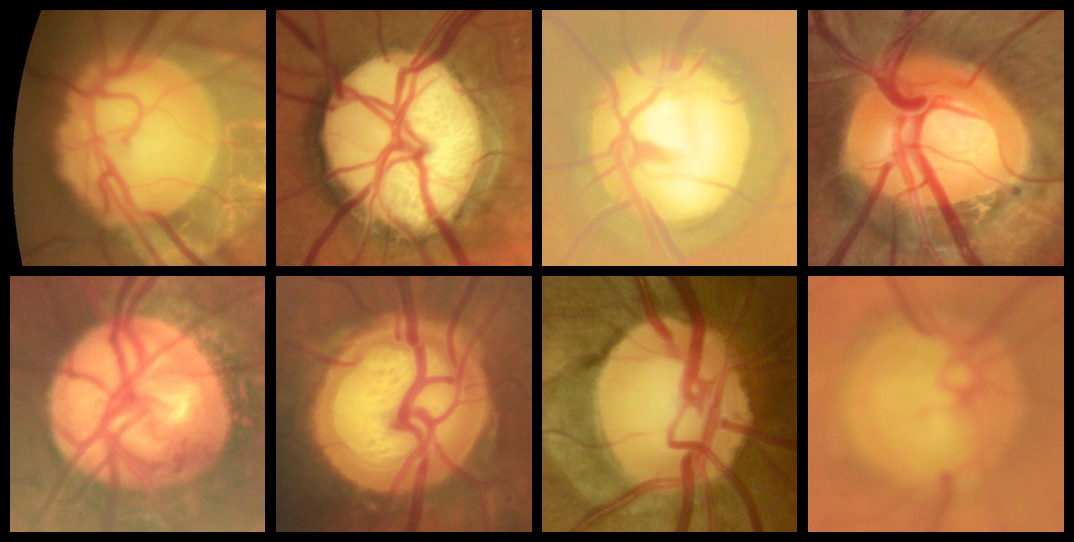

In [ ]:
#@title Cropped Samples from Glaucoma-Positive Images
imgs = []

for im_name in os.listdir('./glc_cropped')[10:18]:
    sample_im = Image.open(f"./glc_cropped/{im_name}")
    sample_im.thumbnail((256,256))
    
    imgs.append(sample_im)

grid = image_grid(imgs, 2, 4)
grid

#### Save output


In [ ]:
!mkdir ./drive/MyDrive/Datasets/Glaucoma/glc_cropped
!cp -r ./glc_cropped/* ./drive/MyDrive/Datasets/Glaucoma/glc_cropped/

!mkdir ./drive/MyDrive/Datasets/Glaucoma/normal_cropped
!cp -r ./normal_cropped/* ./drive/MyDrive/Datasets/Glaucoma/normal_cropped/